In [ ]:
import os
import sys
import math
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from collections import Counter
import imutils
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.backend import resize_images

In [ ]:
import urllib
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

In [ ]:
import os
import sys
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import model_from_json
from tensorflow.keras import layers

In [ ]:
class_weight = {
    0: 2.0,
    1: 2.0,
    2: 2.0,
    3: 3.0,
    4: 1.0,
    5: 2.0,
    6: 4.0,
    7: 2.0,
    8: 2.0,
    9: 2.0,
    10:3.0,
    11:3.0,
    12:2.0,
    13:3.0,
    14:1.0,
    15:1.0,
    16:2.0,
    17:1.0,
    18:2.0,
    19:1.0,
    20:2.0,
    21:2.0,
    22:1.0,
    23:2.0,
    24:3.0,
}

# Data loading

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

data = np.load('/content/drive/My Drive/data_all.npz')
X_tr = data['arr_0']
Y_tr = data['arr_4']
# X_canny = data['arr_1']
# X_canny = np.reshape(X_canny,(X_canny.shape[0],100,100,1))
Y_tr = to_categorical(Y_tr,num_classes=25)
z = np.random.permutation(X_tr.shape[0])
X_tr = X_tr[z]
Y_tr = Y_tr[z]
# X_canny = X_canny[z]

X_train = X_tr[:((3*X_tr.shape[0])//4)]
# X_canny_train = X_canny[:((3*X_canny.shape[0])//4)]
Y_train = Y_tr[:((3*X_tr.shape[0])//4)]

X_test = X_tr[((3*X_tr.shape[0])//4):]
# X_canny_test = X_canny[((3*X_canny.shape[0])//4):]
Y_test = Y_tr[((3*X_tr.shape[0])//4):]




# This part is for multi input pipeline

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices(({"full_image":X_train,"canny_image":X_canny_train},{"final_out":Y_train}))
test_dataset = tf.data.Dataset.from_tensor_slices(({"full_image":X_test,"canny_image":X_canny_test},{"final_out":Y_test}))


def convert(d1,d2):
    image1 = d1['full_image']
    image1 = tf.image.convert_image_dtype(image1, tf.float32)
    image2 = d1['canny_image']
    label = d2['final_out']
    return {"full_image":image1,"canny_image":image2},{"final_out":label}

def augment(d1,d2):
    image = d1["full_image"]
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 106, 106) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[100, 100, 3]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5)
    image_canny = d1["canny_image"]
    label = d2["final_out"]
    return {"full_image":image,"canny_image":image_canny},{"final_out":label}

augmented_train_batches = (
    train_dataset.shuffle(buffer_size=1024).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE).repeat()
) 

validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)
# train_dataset.map(augment,num_parallel_calls=AUTOTUNE)

# This part is the single input pipeline we are using

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,Y_test))

def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    return image, label


def augment(image,label):
    # image,label = convert(image, label)
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 106, 106) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[100, 100, 3]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

    return image,label

augmented_train_batches = (
    train_dataset.shuffle(buffer_size=1024).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE).repeat()
) 

validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)




## This is the model for single input

In [ ]:

def model(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  

    """
    X_input = Input(shape=input_shape, name="full_image")

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(name = 'bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.5)(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool_1')(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(name = 'bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3)(X)

    #  # MAXPOOL
    # X = MaxPooling2D((2, 2), name='max_pool_2')(X)

    # # CONV -> BN -> RELU Block applied to X
    # X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv2')(X)
    # X = BatchNormalization(name = 'bn2')(X)
    # X = Activation('relu')(X)
    # X = Dropout(rate=0.2)(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    # X = Dropout(rate=0.5)(X)
    X = Dense(25, activation='softmax', name='FC')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X)

    return model

# Below is the model for multi input

In [ ]:
X_input = Input(shape=(100,100,1))
X = ZeroPadding2D((3, 3))(X_input)
X = Conv2D(16, (7, 7), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(name = 'bn0')(X)
X = Activation('relu')(X)
X = Dropout(rate=0.5)(X)
X = MaxPooling2D((2, 2), name='max_pool_1')(X)
X = Conv2D(32, (5, 5), strides = (1, 1), name = 'conv1')(X)
X = BatchNormalization(name = 'bn1')(X)
X = Activation('relu')(X)
X = Dropout(rate=0.3)(X)
out = Flatten()(X)

X_input1 = Input(shape=(100,100,3))
X1 = ZeroPadding2D((3, 3))(X_input1)
X1 = Conv2D(16, (7, 7), strides = (1, 1), name = 'conv0')(X1)
X1 = BatchNormalization(name = 'bn0')(X1)
X1 = Activation('relu')(X1)
X1 = Dropout(rate=0.5)(X1)
X1 = MaxPooling2D((2, 2), name='max_pool_1')(X1)
X1 = Conv2D(32, (5, 5), strides = (1, 1), name = 'conv1')(X1)
X1 = BatchNormalization(name = 'bn1')(X1)
X1 = Activation('relu')(X1)
X1 = Dropout(rate=0.3)(X1)
out1 = Flatten()(X1)

encoder1 = Model(inputs = X_input,outputs = out)
encoder2 = Model(inputs = X_input1,outputs = out1)

full_im = Input(shape=(100,100,3), name="full_image")
branch1 = encoder2(full_im)
canny_im = Input(shape=(100,100,1),name="canny_image")
branch2 = encoder1(canny_im)
final_encoding = layers.concatenate([branch1,branch2])
final_out = Dense(25, activation='softmax', name='final_out')(final_encoding)

model_final = Model(inputs=[full_im,canny_im],outputs=final_out)
model_final.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

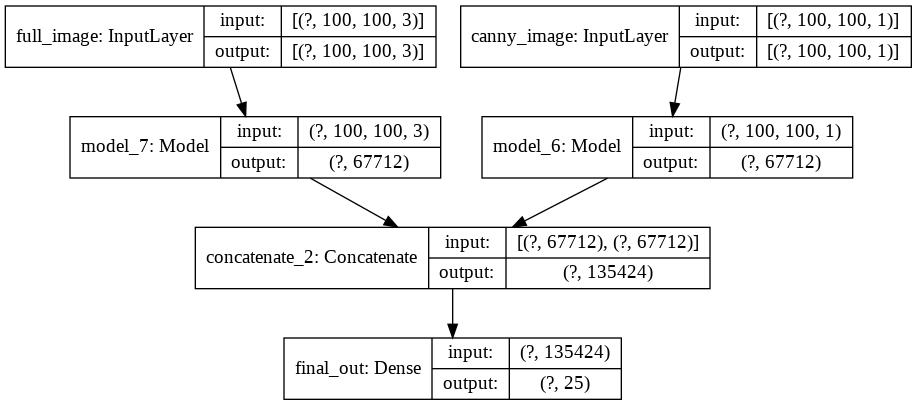

In [ ]:
tf.keras.utils.plot_model(model_final, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
model_final.fit(augmented_train_batches,epochs=20,steps_per_epoch=X_train.shape[0]//BATCH_SIZE,validation_data=validation_batches)

Epoch 1/20
148/148 [==============================] - 12s 82ms/step - loss: 4.7273 - accuracy: 0.8542 - val_loss: 0.0520 - val_accuracy: 0.9908
Epoch 2/20
148/148 [==============================] - 12s 81ms/step - loss: 0.0780 - accuracy: 0.9881 - val_loss: 0.1626 - val_accuracy: 0.9699
Epoch 3/20
148/148 [==============================] - 12s 81ms/step - loss: 0.0712 - accuracy: 0.9915 - val_loss: 0.1198 - val_accuracy: 0.9861
Epoch 4/20
148/148 [==============================] - 12s 81ms/step - loss: 0.0512 - accuracy: 0.9925 - val_loss: 0.5373 - val_accuracy: 0.9531
Epoch 5/20
148/148 [==============================] - 12s 80ms/step - loss: 0.1050 - accuracy: 0.9898 - val_loss: 0.0782 - val_accuracy: 0.9918
Epoch 6/20
148/148 [==============================] - 12s 80ms/step - loss: 0.0544 - accuracy: 0.9949 - val_loss: 0.1565 - val_accuracy: 0.9810
Epoch 7/20
148/148 [==============================] - 12s 80ms/step - loss: 0.0358 - accuracy: 0.9968 - val_loss: 0.1616 - val_accuracy:

## Model Aug is the single input model 

In [ ]:
from keras.optimizers import Adam
model_aug = model(X_train.shape[1:])
model_aug.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])
model_aug.summary()

In [ ]:
model_aug.fit(augmented_train_batches,class_weight=class_weight,epochs=50,steps_per_epoch=X_train.shape[0]//BATCH_SIZE,validation_data=validation_batches)

Epoch 1/50
148/148 [==============================] - 7s 47ms/step - loss: 7.7646 - accuracy: 0.7310 - val_loss: 3.3309 - val_accuracy: 0.2798
Epoch 2/50
148/148 [==============================] - 7s 46ms/step - loss: 0.3184 - accuracy: 0.9544 - val_loss: 0.6886 - val_accuracy: 0.7695
Epoch 3/50
148/148 [==============================] - 7s 46ms/step - loss: 0.2590 - accuracy: 0.9680 - val_loss: 0.0440 - val_accuracy: 0.9870
Epoch 4/50
148/148 [==============================] - 7s 46ms/step - loss: 0.1562 - accuracy: 0.9810 - val_loss: 0.0602 - val_accuracy: 0.9835
Epoch 5/50
148/148 [==============================] - 7s 46ms/step - loss: 0.4289 - accuracy: 0.9614 - val_loss: 0.0391 - val_accuracy: 0.9908
Epoch 6/50
148/148 [==============================] - 7s 46ms/step - loss: 0.1517 - accuracy: 0.9842 - val_loss: 0.0280 - val_accuracy: 0.9949
Epoch 7/50
148/148 [==============================] - 7s 46ms/step - loss: 0.1363 - accuracy: 0.9875 - val_loss: 0.0361 - val_accuracy: 0.9921

In [ ]:
model_final.save('trial_all_class_weights_multi_input.h5')

In [ ]:
model_aug.save('trial_all_class_weight.h5')